# Image filtering

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Seungyeop Lee (seungyeoplee@inha.edu) </div>_

<br>

---

## Image Convolution

The convolution operation for images is illustrated as follows.

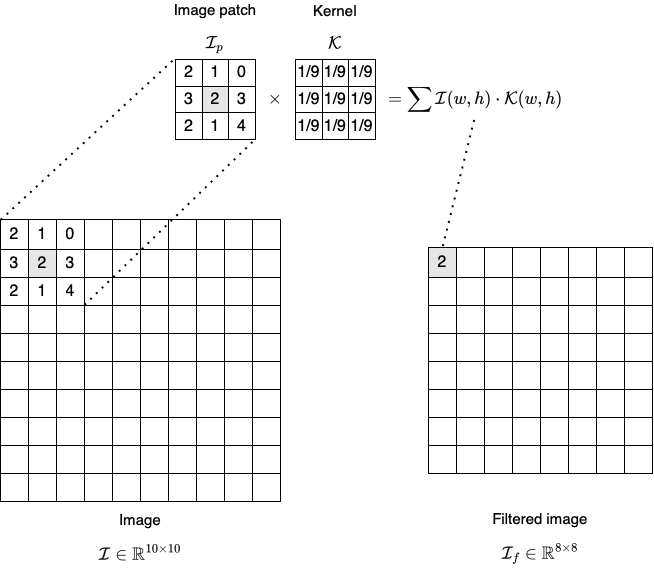

<br>

_**(Problem 1)**_ Now, implement a custom convolution function that takes an image and a kernel as inputs and returns the result of the convolution operation.

In [1]:
import numpy              as np
import numpy.linalg       as nl
import matplotlib.pyplot  as plt
import time
import cv2
import requests

def convolve(image, kernel):
    h_i, w_i = image.shape
    h_k, w_k = kernel.shape

    h_o = h_i - h_k + 1
    w_o = w_i - w_k + 1

    image_conv = np.zeros((h_o, w_o))

    # your code here ----------------------------------------------------------#
    for i in range(h_o) :
        for j in range(w_o) :
            convolve_value = np.sum(image[i:i+h_k, j:j+w_k] * kernel)
            image_conv[i,j] = convolve_value
    # -------------------------------------------------------------------------#

    return image_conv

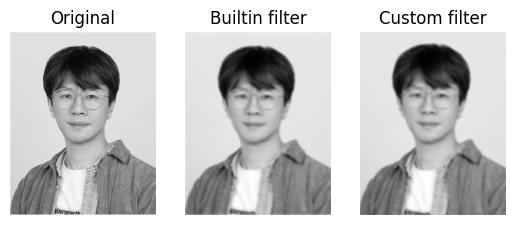

In [2]:
def load_image_from_url(url):
    response = requests.get(url)
    image_array = np.frombuffer(response.content, np.uint8)
    img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return img

def visualize(imgs, titles, cmap='gray'):
  n = len(imgs)
  fig, axs = plt.subplots(1, n)
  if n == 1:
    axs.imshow(imgs[0], cmap=cmap)
    axs.set_title(titles[0])
    axs.axis('off')
  else:
    for i in range(n):
      axs[i].imshow(imgs[i], cmap=cmap)
      axs[i].set_title(titles[i])
      axs[i].axis('off')
  plt.show()

img_link = "https://jonghank.github.io/jhk-2024.jpg"

img = load_image_from_url(img_link)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_gray_raw = cv2.resize(img, None, fx=0.25, fy=0.25)

kernel_mean = 1/100 * np.ones((10,10), dtype=np.float16)

img_gray_flt_cv2 = cv2.filter2D(img_gray_raw, -1, kernel_mean)
img_gray_flt_cus = convolve(img_gray_raw, kernel_mean)

visualize([img_gray_raw, img_gray_flt_cv2, img_gray_flt_cus], ['Original', 'Builtin filter', 'Custom filter'])

<br>


---


## Padding

As shown in the image, when implementing convolution, you can observe that the image size decreases depending on the size of the kernel. For this reason, when you want to maintain the original image size after convolution, you need to expand the image before applying the convolution to match the size of the kernel. This is known as "Padding", and depending on how the expanded area is filled, there are different padding methods.

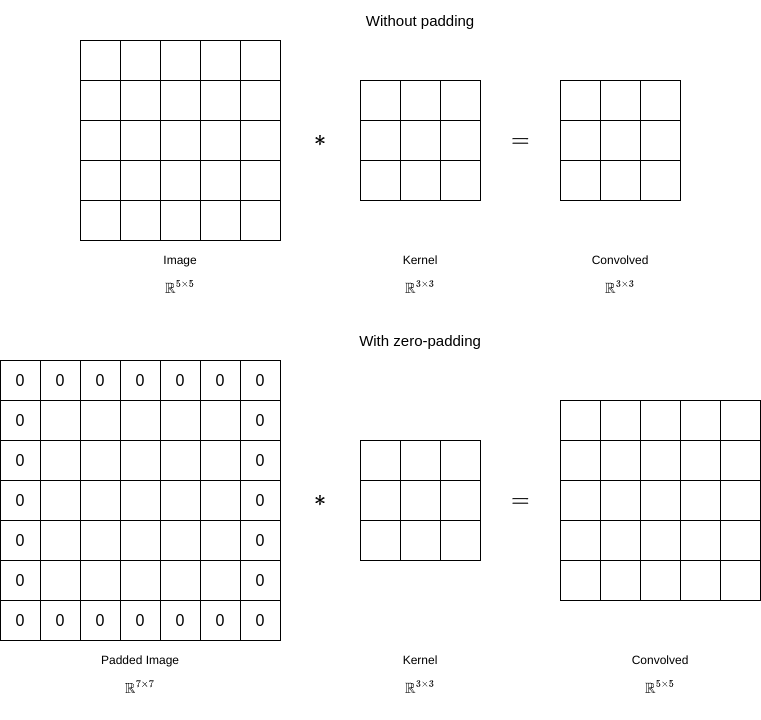

As illustrated above, filling with zeros is called "zero-padding", and there are other methods as well, such as filling the padding area by replicating the pixels at the edges.

<br>

_**(Problem 2)**_ Complete the image zero-padding function.

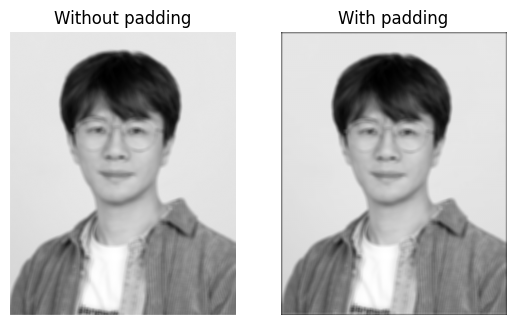

Original image                  :  (708, 565)
Convolved image without padding :  (699, 556)
Convolved image with padding    :  (708, 565)


In [3]:
def zero_padding(image, kernel):
    h_i, w_i = image.shape
    h_k, w_k = kernel.shape

    # your code here ----------------------------------------------------------#
    h_padding_size = h_i+ 2* (h_k//2)
    w_padding_size = w_i+ 2*(w_k//2)
    image_pad = np.zeros((h_padding_size, w_padding_size))

    for i in range(h_i) :
        for j in range(w_i) :
            image_pad[i+h_k//2, h_k//2+j] = image[i,j]
    # -------------------------------------------------------------------------#

    return image_pad

def convolve_zero_padded(image, kernel):
    h_i, w_i = image.shape
    h_k, w_k = kernel.shape

    image_padded = zero_padding(image, kernel)
    image_conv = np.zeros((h_i, w_i))

    for i in range(h_i):
        for j in range(w_i):
            image_conv[i, j] = np.sum(image_padded[i : i + h_k, j : j + w_k] * kernel)

    return image_conv

img_gray_flt_cus_zp = convolve_zero_padded(img_gray_raw, kernel_mean)

visualize([img_gray_flt_cus,img_gray_flt_cus_zp], ['Without padding', 'With padding'])

print("Original image                  : ",img_gray_raw.shape)
print("Convolved image without padding : ",img_gray_flt_cus.shape)
print("Convolved image with padding    : ",img_gray_flt_cus_zp.shape)

<br>

---

## Matrix-wise implementation of image convolution

If you implemented the convolution using a `for` loop, you may notice that the operation is quite slow. This is due to the limitations of the Python language, as its core functions are not optimized for speed. On the other hand, libraries like NumPy, which are built on C, can perform matrix operations at much higher speeds. By leveraging NumPy's matrix operations, we can significantly improve the speed of the convolution operation.

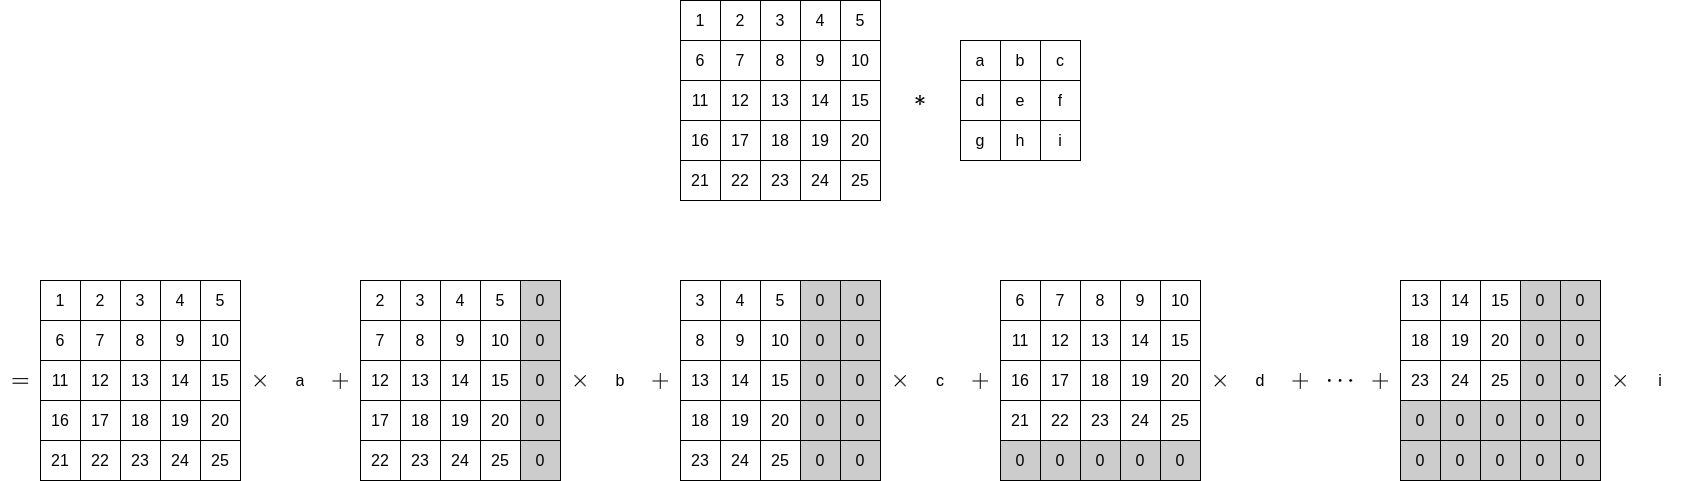

If the total number of elements in the kernel is $ N_k $, as shown above, the convolution can be represented as the weighted sum of $ N_k $ shifted images, where each image corresponds to a region of the input image. Now, let's implement the convolution operation using this approach and compare its runtime with the one implemented previously.

<br>

_**(Problem 3)**_ Implement the matrix-wise convolution function.

( Hint. Use `np.roll()` function. )

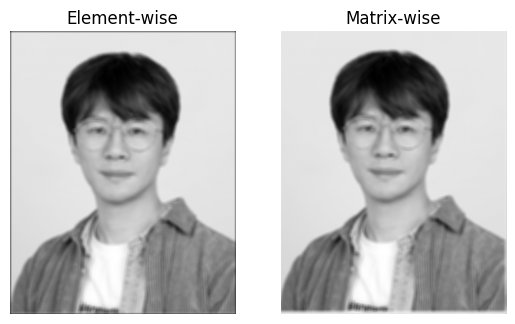

Element-wise elapsed time [s]   :  1.1408708095550537
Matrix-wise elapsed time [s]    :  0.11834192276000977


In [4]:
def convolve_mtx(image, kernel):
    h_i, w_i = image.shape
    h_k, w_k = kernel.shape

    image_conv = np.zeros((h_i, w_i))

    # your code here ----------------------------------------------------------#
    # zero-padding
    pad_image = np.zeros((h_i + h_k, w_i + w_k))
    pad_image[0:h_i,0:w_i] = image

    # convolution
    for i in range(w_k):
      for j in range(h_k):
        pad_image[:h_i,:w_i] = image
        pad_image = np.roll(pad_image,shift=(-i,-j),axis=(0,1))
        image_conv[:,:] = image_conv[:,:] + (pad_image[:h_i,:w_i] * kernel[i,j])
    # -------------------------------------------------------------------------#

    return image_conv

start = time.time()
img_gray_flt_cus_zp  = convolve_zero_padded(img_gray_raw, kernel_mean)
elapsed_cus_zp = time.time() - start

start = time.time()
img_gray_flt_cus_mtx = convolve_mtx(img_gray_raw, kernel_mean)
elapsed_cus_mtx = time.time() - start

visualize([img_gray_flt_cus_zp,img_gray_flt_cus_mtx], ['Element-wise', 'Matrix-wise'])
print("Element-wise elapsed time [s]   : ", elapsed_cus_zp)
print("Matrix-wise elapsed time [s]    : ", elapsed_cus_mtx)


You could see that matrix-wise operations are relatively faster than element-wise operations. The difference in computation time becomes more pronounced as the image size increases.

<br>

---

## Image noise filtering

Let us design filters to remove noise from an image using convolution operations.

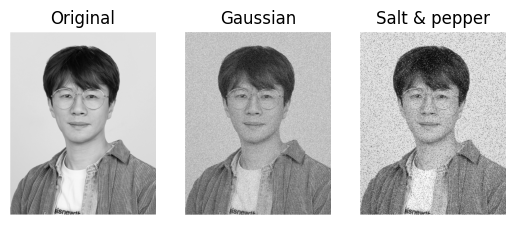

In [5]:
img_gray_noisy_gausian = img_gray_raw.copy() + 100*np.random.rand(*img_gray_raw.shape)
img_gray_noisy_salt_pepper = img_gray_raw.copy()

random_mask = np.random.rand(*img_gray_raw.shape)
salt_mask = np.where(random_mask > 0.95)
pepper_mask = np.where(random_mask < 0.05)
img_gray_noisy_salt_pepper[salt_mask] = 255
img_gray_noisy_salt_pepper[pepper_mask] = 0

visualize([img_gray_raw, img_gray_noisy_gausian, img_gray_noisy_salt_pepper], ['Original', 'Gaussian', 'Salt & pepper'])

<br>

---


### Gaussian blur


To implement Gaussian blur, the kernel should be constructed with elements corresponding to values of a Gaussian distribution, with the center of the kernel being the mean point.

$$
\mathbf{K}(w,h) = {1\over \sqrt{2\pi\sigma^2}}\exp{\Big(-{(w-c_w)^2 + (h-c_h)^2\over2\sigma^2}\Big)}
$$

Where $(c_w,c_h)$ is a center pixel of the kernel.

<br>

_**(Problem 4)**_ Implement the function that outputs the Gaussian kernel.

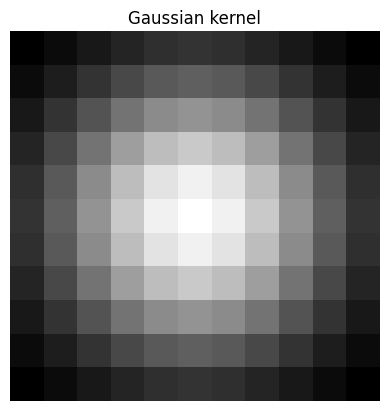

In [6]:
def kernel_gaussian(size, sigma):
    kernel = np.zeros((size, size))

    # your code here ----------------------------------------------------------#
    center = size//2 
    for w in range(size) :
        for h in range(size) :
            kernel[w,h] = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-((w-center)**2+(h-center)**2)/2/sigma**2)
    # -------------------------------------------------------------------------#

    return kernel

kernel_g = kernel_gaussian(11, 3)

visualize([kernel_g], ['Gaussian kernel'])

The results of Gaussian blur through this Gaussian kernel to a noisy image are as follows.

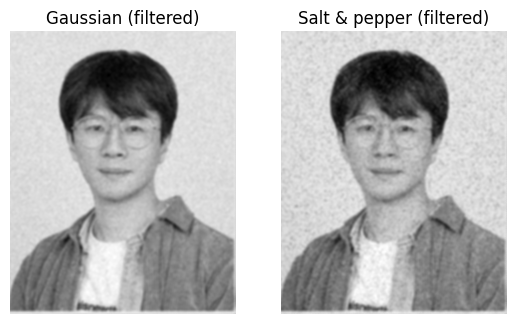

In [7]:
img_gray_flt_g_g  = convolve_mtx(img_gray_noisy_gausian, kernel_g)
img_gray_flt_sp_g = convolve_mtx(img_gray_noisy_salt_pepper, kernel_g)

visualize([img_gray_flt_g_g, img_gray_flt_sp_g], ['Gaussian (filtered)', 'Salt & pepper (filtered)'])

<br>

---

### Nonlinear filter : Median filter

The filters introduced earlier, such as the mean filter and Gaussian filter, are linear filters. However, there are also nonlinear filters where the operation between the kernel and the image patch is nonlinear. One of the most representative nonlinear filters is the Median filter, which outputs the median value among the elements of the image patch.

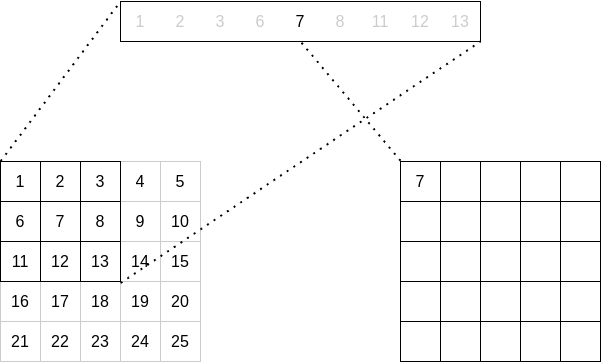

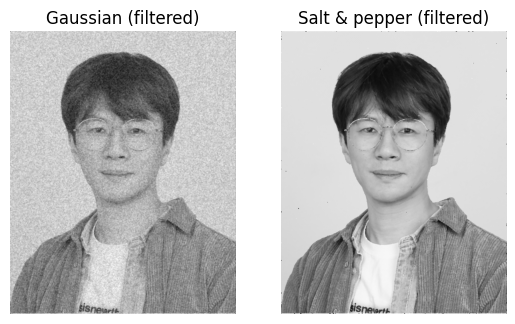

In [8]:
def median_filter(image, kernel_size):

    h_i, w_i = image.shape

    image_flt = np.zeros((h_i, w_i))

    image_padded = zero_padding(image, np.zeros((kernel_size,kernel_size)))

    # your code here ----------------------------------------------------------#
    for i in range(h_i) :
        for j in range(w_i) :
            image_flt[i, j] = np.median(image_padded[i:i+kernel_size, j:j+kernel_size])
    # -------------------------------------------------------------------------#

    return image_flt

img_gray_flt_g_m  = median_filter(img_gray_noisy_gausian, 3)
img_gray_flt_sp_m = median_filter(img_gray_noisy_salt_pepper, 3)

visualize([img_gray_flt_g_m, img_gray_flt_sp_m], ['Gaussian (filtered)', 'Salt & pepper (filtered)'])

As can be seen from the results above, the median filter performs well in removing salt-and-pepper noise.